# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from pprint import pprint

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

%matplotlib inline

# Flow-chart       
<code>
          Start
            |
        Data Pure?
            |
    yes ---   ---    no 
     |                |
  classify     potential_splits
     |                |
    stop     lowest overall_entropy
                      |
                   split data
                      |
           <= || ==  - -  > || !=
</code>

# Load data
- Note: will work with iris dataset to focus on implementation, rather than data processing

In [2]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
# rename column headers
col_names = {
    "sepal length (cm)" : "sepal_length",
    "sepal width (cm)" : "sepal_width",
    "petal length (cm)" : "petal_length",
    "petal width (cm)" : "petal_width"
}

df = df.rename(columns=col_names)

In [4]:
# set target
target = iris.target
target

# combine target with df with names of labels
df['label'] = iris.target_names[target]
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Helper functions for data processing

## Custom train-test-split function

In [5]:
def train_test_split(df, target, test_size, separate_test=True):
    # if test_size is a proportion
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
        
    # combine df and target
    df['label'] = target
    
    # get random sample
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    
    X_test = df.loc[test_indices]
    X_train = df.drop(test_indices)
    
    # whether or not to return targets separately
    if separate_test:
        y_test = df.loc[test_indices]['label']
        y_train = df.drop(test_indices)['label']
        
        return X_train, X_test, y_train, y_test
    else:
        return X_train, X_test

In [6]:
random.seed(0)
X = df.drop('label', axis=1)
y = iris.target_names[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)
print(X_test.shape)
print(y_test.shape)

(15, 5)
(15,)


## Get feature types function
- feature values are strings: categorical
- feature values are numeric: unique_vals <= threshold are categorical, otherwise continuous
- note: threshold is arbitrary and can be adjusted

In [7]:
def get_feature_types(df, threshold=15):
    feature_types = []
    
    for col in df.columns:
        unique_vals = df[col].unique()
        example_val = unique_vals[0]
        
        if (isinstance(example_val, str)) or (len(unique_vals) <= threshold):
            feature_types.append("categorical")
        else:
            feature_types.append("continuous")
    return feature_types

In [8]:
FEATURE_TYPES = get_feature_types(df)
i = 0
for col in df.columns:
    print(col, "-", FEATURE_TYPES[i])
    i += 1

sepal_length - continuous
sepal_width - continuous
petal_length - continuous
petal_width - continuous
label - categorical


# Helper functions for Decision Tree Algorithm
- Check purity
- Classifier
- Potential splits
- Lowest overall entropy
- Split data

In [9]:
df = X_train
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Check purity function
- checks number of unique classes; if equals to 1 then input is pure

In [10]:
def check_purity(data):
    # use label column to determine purity
    label_col = data[:, -1]
    unique_classes = len(np.unique(label_col))
    
    if unique_classes == 1:
        return True
    else:
        return False

In [11]:
# test check_purity function against petal_width
check_purity(df[df['petal_width'] < .8].values) == True

True

## Classification function
- finds number of unique classes and their counts, and returns the unique class with largest count

In [12]:
def classify_data(data):
    # use label column to determine classes
    label_col = data[:, -1]
    unique_classes, unique_classes_counts = np.unique(label_col, return_counts=True)
    
    # set index of class with greatest counts
    majority_index = unique_classes_counts.argmax()
    # return specific class
    return unique_classes[majority_index]

In [13]:
# test classify_data against petal_width
classify_data(df[df['petal_width'] < .8].values) == 'setosa'

True

## Potential splits function
- finds all unique values within data
- continuous value:  creates splits inbetween each unique value
- categorical value: creates splits based on each unique value itself

In [14]:
def get_potential_splits(data, feature_types):
    potential_splits = {}
    _, n_cols = data.shape
    
    # go through each col in matrix
    for col_index in range(n_cols - 1):
        # set key = col_index
        values = data[:, col_index]
        unique_values = np.unique(values)
        
        # continous: split along midway between unique points
        if feature_types[col_index] == "continuous":
            potential_splits[col_index] = []
            # for each unique value, calculate mid point
            for index in range(1,len(unique_values)):
                cur_val = unique_values[index]
                pre_val = unique_values[index - 1]
                potential_split_point = (cur_val + pre_val) / 2
                potential_splits[col_index].append(potential_split_point)
        # categorical: split along unique values directly
        else:
            potential_splits[col_index] = unique_values
            
    return potential_splits

In [15]:
# test get_potential_splits
potential_splits = get_potential_splits(df.values, FEATURE_TYPES)
potential_splits

{0: [4.35,
  4.45,
  4.55,
  4.65,
  4.75,
  4.85,
  4.95,
  5.05,
  5.15,
  5.25,
  5.35,
  5.45,
  5.55,
  5.65,
  5.75,
  5.85,
  5.95,
  6.05,
  6.15,
  6.25,
  6.35,
  6.45,
  6.55,
  6.65,
  6.75,
  6.85,
  6.95,
  7.05,
  7.15,
  7.4,
  7.65,
  7.800000000000001],
 1: [2.1,
  2.25,
  2.3499999999999996,
  2.45,
  2.55,
  2.6500000000000004,
  2.75,
  2.8499999999999996,
  2.95,
  3.05,
  3.1500000000000004,
  3.25,
  3.3499999999999996,
  3.45,
  3.55,
  3.6500000000000004,
  3.75,
  3.8499999999999996,
  3.95,
  4.05,
  4.15,
  4.300000000000001],
 2: [1.05,
  1.15,
  1.25,
  1.35,
  1.45,
  1.55,
  1.65,
  1.7999999999999998,
  2.5999999999999996,
  3.4,
  3.55,
  3.6500000000000004,
  3.75,
  3.8499999999999996,
  3.95,
  4.05,
  4.15,
  4.25,
  4.35,
  4.45,
  4.55,
  4.65,
  4.75,
  4.85,
  4.95,
  5.05,
  5.15,
  5.25,
  5.35,
  5.45,
  5.55,
  5.65,
  5.75,
  5.85,
  5.95,
  6.05,
  6.25,
  6.5,
  6.65,
  6.800000000000001],
 3: [0.15000000000000002,
  0.25,
  0.35,
  0.4

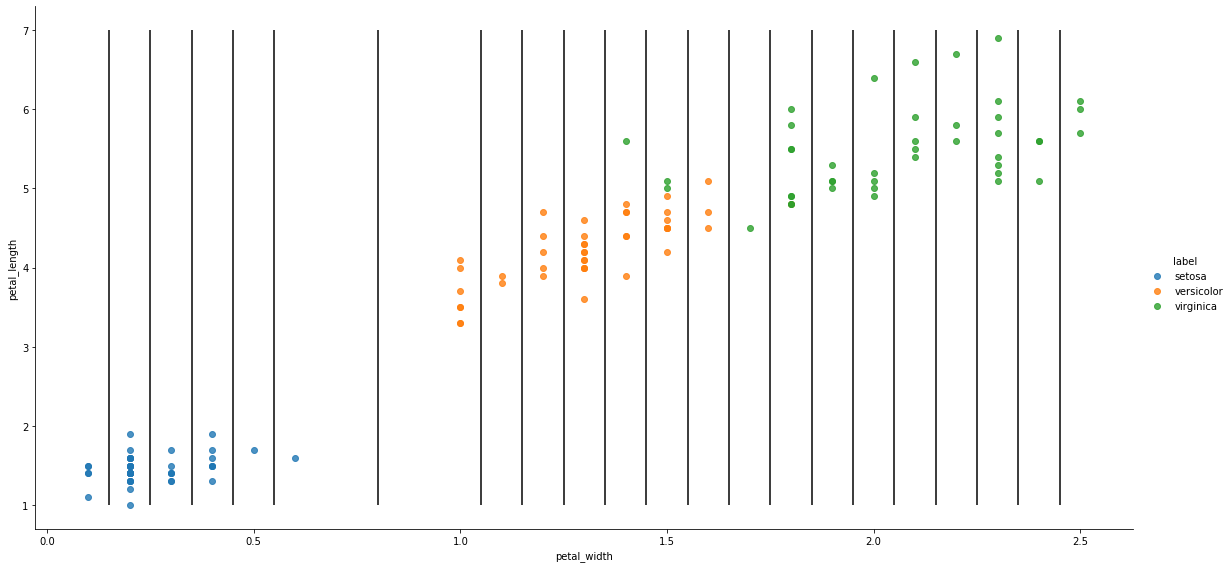

In [16]:
# plot potential splits
sns.lmplot(data=df, x="petal_width", y="petal_length", 
           hue="label", fit_reg=False, height=8, aspect=2);

# check if our splits are all between 2 values, both vertically & horizontally
plt.vlines(x=potential_splits[3], ymin=1, ymax=7);
# plt.hlines(y=potential_splits[2], xmin=0, xmax=2.5);

## Split data function
- splits data along particular column and value
- continuous: 
    - data_below = all values equal to or below split_value
    - data_above = all values above split_value
- categorical: 
    - data_below = all values equal to split_value
    - data_above = all values not equal to split_value

In [17]:
def split_data(data, split_col, split_val, feature_types):
    split_col_vals = data[:, split_col]

    if feature_types[split_col] == "continuous":
        data_below = data[split_col_vals <= split_val]
        data_above = data[split_col_vals > split_val]
    else:
        data_below = data[split_col_vals == split_val]
        data_above = data[split_col_vals != split_val]
        
    return data_below, data_above

In [18]:
# test split_data against feature 3 = petal_width
split_col = 3
split_val = 0.8
data_below, data_above = split_data(df.values, split_col, split_val, FEATURE_TYPES)

(0, 2.6)

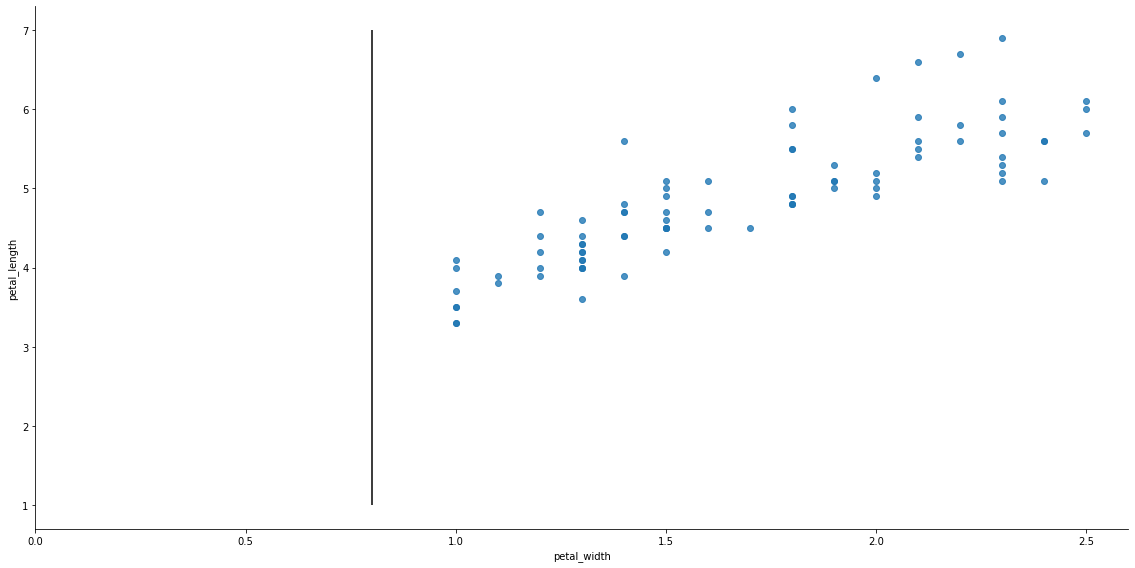

In [19]:
# plot split
plotting_df = pd.DataFrame(data_above, columns=df.columns)

sns.lmplot(data=plotting_df, x="petal_width", y="petal_length", fit_reg=False, height=8, aspect=2)
plt.vlines(x=split_val, ymin=1, ymax=7)
plt.xlim(0, 2.6)

## Lowest overall entropy function
<br/>

<strong>Entropy</strong>  = $\sum_{i=1}^{c} P_i$ * (-log<sub>2</sub> $P_i$ ), where $P_i$ is the probability of an event

       = Weight Sum * Uncentainty Value

<strong>Overall Entropy</strong> = $\sum_{j=1}^{2} P_j$ * <strong>Entropy</strong>

<br/>

In [20]:
def calculate_entropy(data):
    label_col = data[:, -1]
    _, counts = np.unique(label_col, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    
    return entropy

In [21]:
# test calculate_entropy against data_below; should equal 0 as data_below is pure
calculate_entropy(data_below) == 0.0

True

In [22]:
def calculate_overall_entropy(data_below, data_above):
    # total number of data points
    n_data_points = len(data_below) + len(data_above)
    
    # probabilities
    prob_data_below = len(data_below) / n_data_points
    prob_data_above = len(data_above) / n_data_points
    
    overall_entropy = (prob_data_below * calculate_entropy(data_below)
                     + prob_data_above * calculate_entropy(data_above))
        
    return overall_entropy

In [23]:
# test calculate_overall_entropy against data_below and data_above
calculate_overall_entropy(data_below, data_above)

0.6443830256785783

## Best split function


Will loop through all potential_split values and calcuate overall_entropy for every split and returns smallest overall_entropy value

#### Notes:
- algorithm is relatively slow because it has to go through all potential splits = O(n^2). 
- won't perform well with features that have many potential_splits

In [24]:
def determine_best_split(data, potential_splits, feature_types):
    # set initial arbitary overall_entropy
    overall_entropy = 999
    
    for col_index in potential_splits:
        for val in potential_splits[col_index]:
            # split data based on potential_split
            data_below, data_above = split_data(data, split_col=col_index, split_val=val,
                                                feature_types=feature_types)
            cur_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            # update current overall entropy value if smaller
            if cur_overall_entropy <= overall_entropy:
                overall_entropy = cur_overall_entropy
                best_split_col = col_index
                best_split_val = val
                
    return best_split_col, best_split_val

In [25]:
# test determine_best_split with current potential_splits
determine_best_split(df.values, potential_splits, FEATURE_TYPES)

(3, 0.8)

# Decision Tree Algorithm
- with pruning (min_samples, max_depth)

### Tree
<code>
sub_tree = { question : [yes_answer, no_answer] }
</code>

want something like this:
<code>
example_tree = {
    "petal_width <= 0.8": [
        "setosa", {
        "petal_width <= 1.65" : [{
            "petal_width <= 4.9" : 
                 ["versicolor", "viriginica"]},
            "virginica"]
        }]
}
                </code>

In [26]:
def decision_tree_algorithm(df, feature_types, headers, counter=0, min_samples=2, max_depth=5):
    # data preparation:
    #   need to do this step to work with 2D arrays
    if counter == 0:
        headers = df.columns
        data = df.values
    else:
        data = df
    
    # base case: is data pure or
    #  size is less than min_samples or
    #  counter is at max_depth
    if ((check_purity(data)) or 
     (len(data) < min_samples) or 
     (counter == max_depth)):
        classification = classify_data(data)
        return classification
    
    
    counter += 1
    
    # helper functions
    potential_splits = get_potential_splits(data, feature_types)
    split_col, split_val = determine_best_split(data, potential_splits, feature_types)
    data_below, data_above = split_data(data, split_col, split_val, feature_types)
    
    # instantiate sub-tree
    feature_name = headers[split_col]
    type_of_feature = feature_types[split_col]
    
    if type_of_feature == "continuous":
        question = "{} <= {}".format(feature_name, split_val)
    else:
        question = "{} == {}".format(feature_name, split_val)
        
    sub_tree = {question: []}
    
    # recursively find answers
    yes_answer = decision_tree_algorithm(data_below, feature_types, headers, 
                                         counter, min_samples, max_depth)
    no_answer = decision_tree_algorithm(data_above, feature_types, headers, 
                                        counter, min_samples, max_depth)
    
    # if answers are the same, just assign one
    if yes_answer == no_answer:
        sub_tree = yes_answer
    else:
        sub_tree[question].append(yes_answer)
        sub_tree[question].append(no_answer)
        
    return sub_tree

In [27]:
tree = decision_tree_algorithm(df=df, feature_types=FEATURE_TYPES, headers=df.columns, max_depth=3)
pprint(tree)

{'petal_width <= 0.8': ['setosa',
                        {'petal_width <= 1.65': [{'petal_length <= 4.95': ['versicolor',
                                                                           'virginica']},
                                                 'virginica']}]}


## Classification

- recursively traverses down the tree and answers questions until reaches a leaf node
- continuous: comparison_op:  "<=" float(value)
- categorical: comparison_op: "==" value

In [28]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_op, value = question.split()
    
    # ask question:
    if comparison_op == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # base case: if answer is not a dictionary
    if not isinstance(answer, dict):
        return answer
    
    # otherwise recurse
    return classify_example(example, answer)

In [29]:
example = df.iloc[0]
example

sepal_length       5.1
sepal_width        3.5
petal_length       1.4
petal_width        0.2
label           setosa
Name: 0, dtype: object

In [30]:
classify_example(example, tree) == df.iloc[0]["label"]

True

# SciKit-Learn pattern

In [31]:
class DecisionTreeClassifier():  
    # constructor
    def __init__ (self, min_samples=2, max_depth=5, threshold=15):
        self.min_samples = min_samples
        self.max_depth = max_depth
        
        # threshold for categorical determination
        self.threshold = threshold
        self.tree = []
        self.feature_types = []
        self.col_headers = []
    
    def combine_with_label(self,X, y):
        new_df = X.copy()
        new_df['label'] = y
        return new_df
    
    # algorithm:
    algorithm = decision_tree_algorithm
    
    # sklearn APIs:
    def fit(self, X, y):
        # combine X and y to one df
        new_df = X.copy()
        new_df['label'] = y
        
        # set feature_types and col_headers
        self.feature_types = get_feature_types(X, self.threshold)
        self.col_headers = X.columns.values
        
        # run algorithm to generate decision tree
        self.tree = decision_tree_algorithm(new_df, self.feature_types, self.col_headers,
                                            min_samples=self.min_samples, max_depth=self.max_depth)
        
    def predict(self, X):
        num_examples, _ = X.shape
        predictions = []
        
        for i in range(num_examples):
            predictions.append(classify_example(X.iloc[i], self.tree))
        
        return np.array(predictions)

# Machine Learning

## Create train and test splits

In [48]:
# separating label column from df
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, separate_test=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108, 5)
(27, 5)
(108,)
(27,)


## Estimator

In [58]:
dt = DecisionTreeClassifier()

## Fit the model

In [59]:
dt.fit(X_train, y_train)

## Make predictions

In [60]:
test_pred = dt.predict(X_test)

# Metrics

### Accuracy

In [61]:
print(accuracy_score(y_test, test_pred))

0.9629629629629629


### F1 Score

In [62]:
print(f1_score(y_test, test_pred, average='micro'))

0.9629629629629629


### Confusion matrix

In [63]:
pd.crosstab(y_test, test_pred, 
            rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species,setosa,versicolor,virginica
Actual Species,,,
setosa,10,0,0
versicolor,0,10,1
virginica,0,0,6
